#Memes Classification Using & Fine-Tuning Deep Learning Model - VGG16 

---




###Background
Toady, memes have become a new language for millenials on social media. With billions of memes out there- political, funny, informative, fan theory, etc. people have been sharing them on social media majorly for entertainment. At times these memes have a purpose beyond entertainment. They are shared to spread information and sentiments regarding political, economic and social issues. This also leads to spread of disinformation. With today's advancement in technology,data science and AI, it is possible to identify if these memes are facts or just mere wrong information. However, before identifying that it is necessary to build a model that can classify memes and non-meme images. In this project I used pre-trained VGG-16 neural net models and fine tuned them to increase their accuracy in classifying memes and non-meme images. 

###Data 
The data used in this project was scraped and downloaded from various sources. A total of 16000 images (8000 images for each class) have been used in training the models. The image sources are Bing Image Search and Kaggle Dataset. For Bing Image Search , I used a bing images python script with different arguments.The images were then renamed as 'meme_#.jpg' and 'non_meme_#.jpg' (# is the number) using a python script. To make sure there were no duplicates or false memes / non-memes I manually checked for duplicates and deleted them. 





###Sample Memes

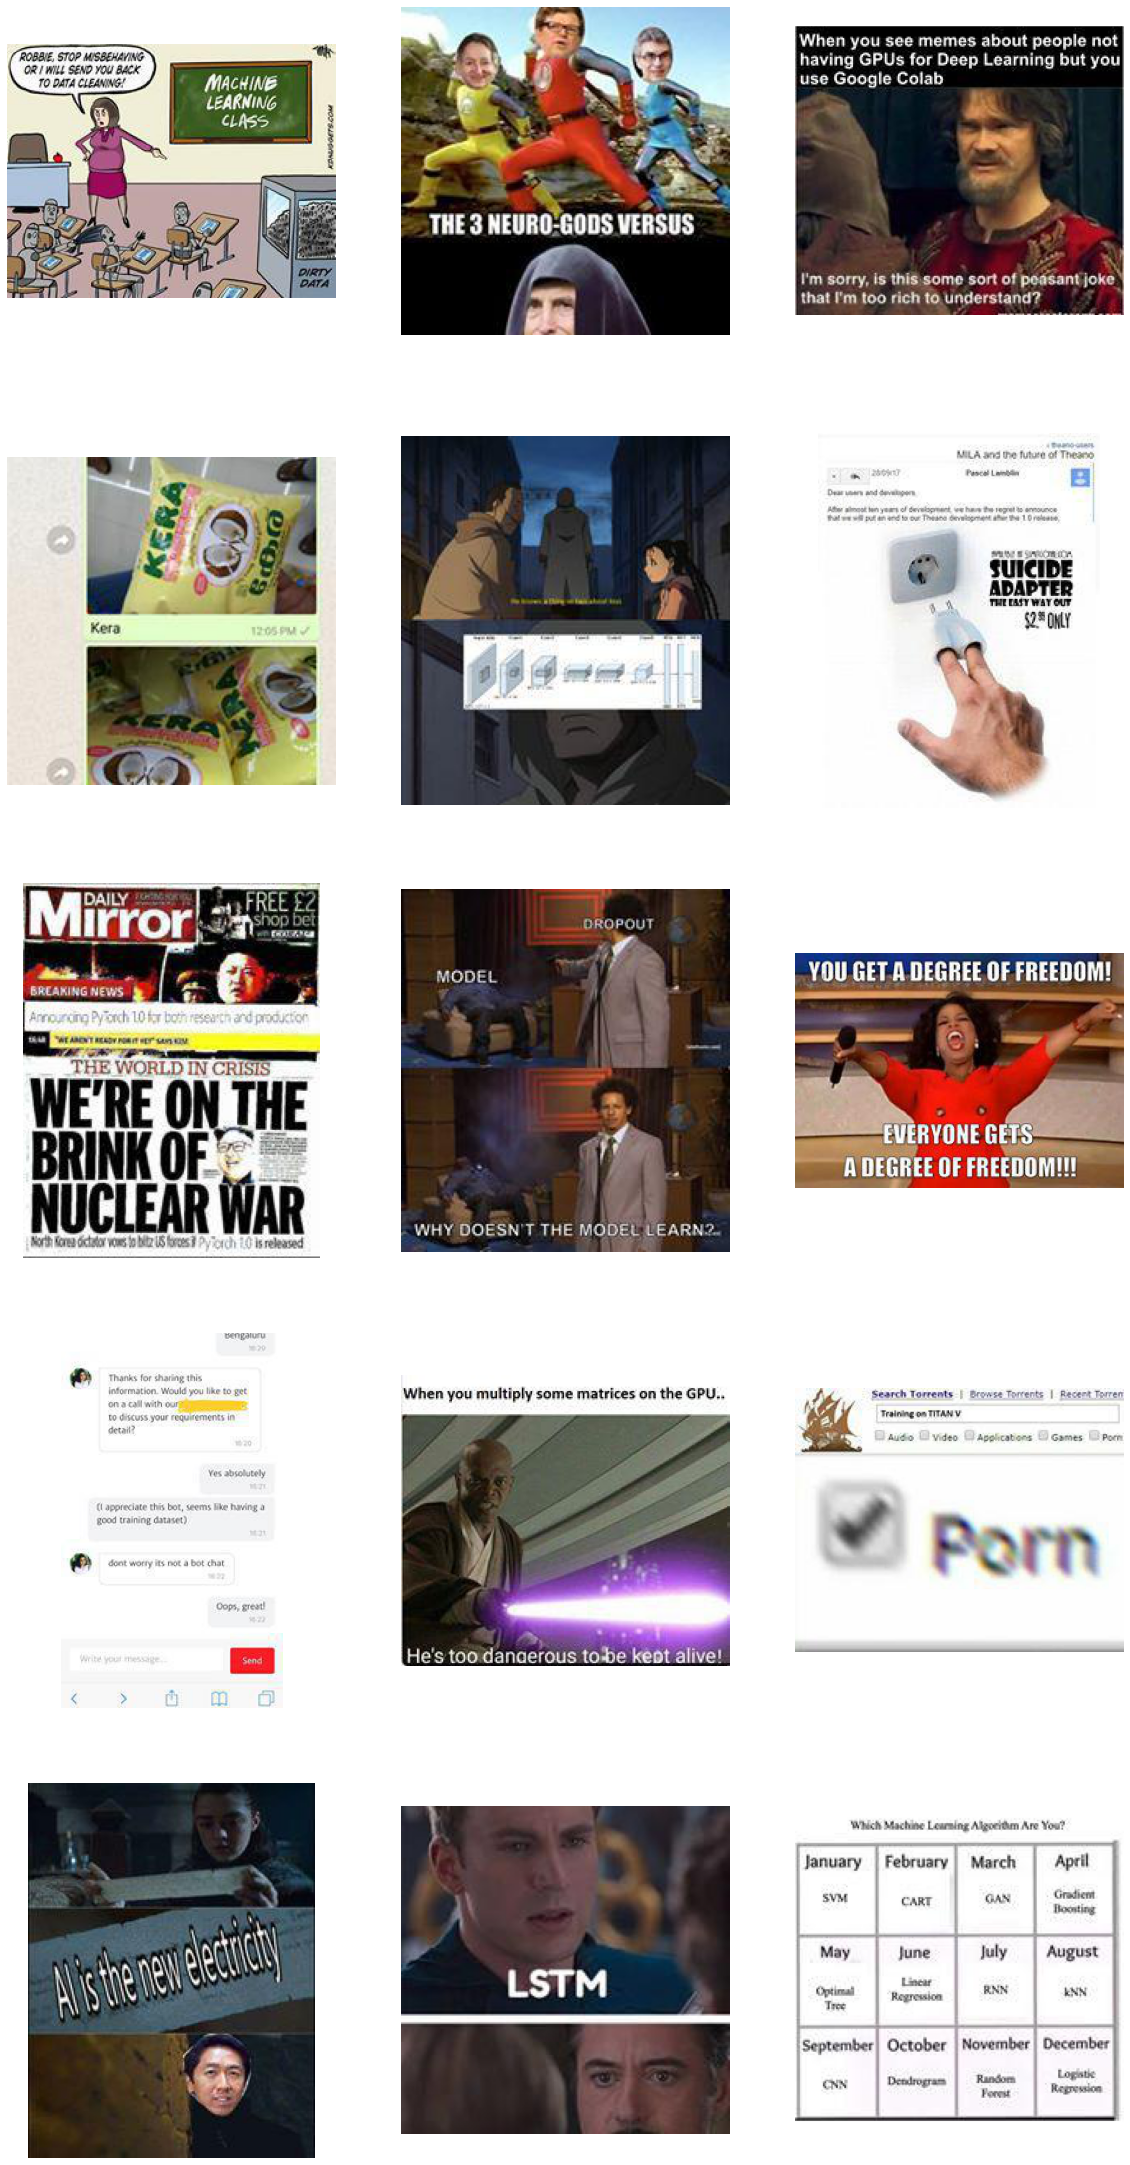

In [30]:
#@title
#Code for displaying sample memes
import PIL
rows = 5
path= '/content/drive/My Drive/Memes_Project/Data/memes_vs_non_memes/train/meme'

os.chdir(path)
files=os.listdir(path)
files=files[20:35]


plt.figure(figsize=(20,40))
for num, f in enumerate(files):
  try:
    img = PIL.Image.open(f)
    plt.subplot(rows,3,num+1)
    plt.axis('off')
    plt.imshow(img)

  except Exception as e:  # in the interest in keeping the output clean...
    pass

###Sample Non-Memes

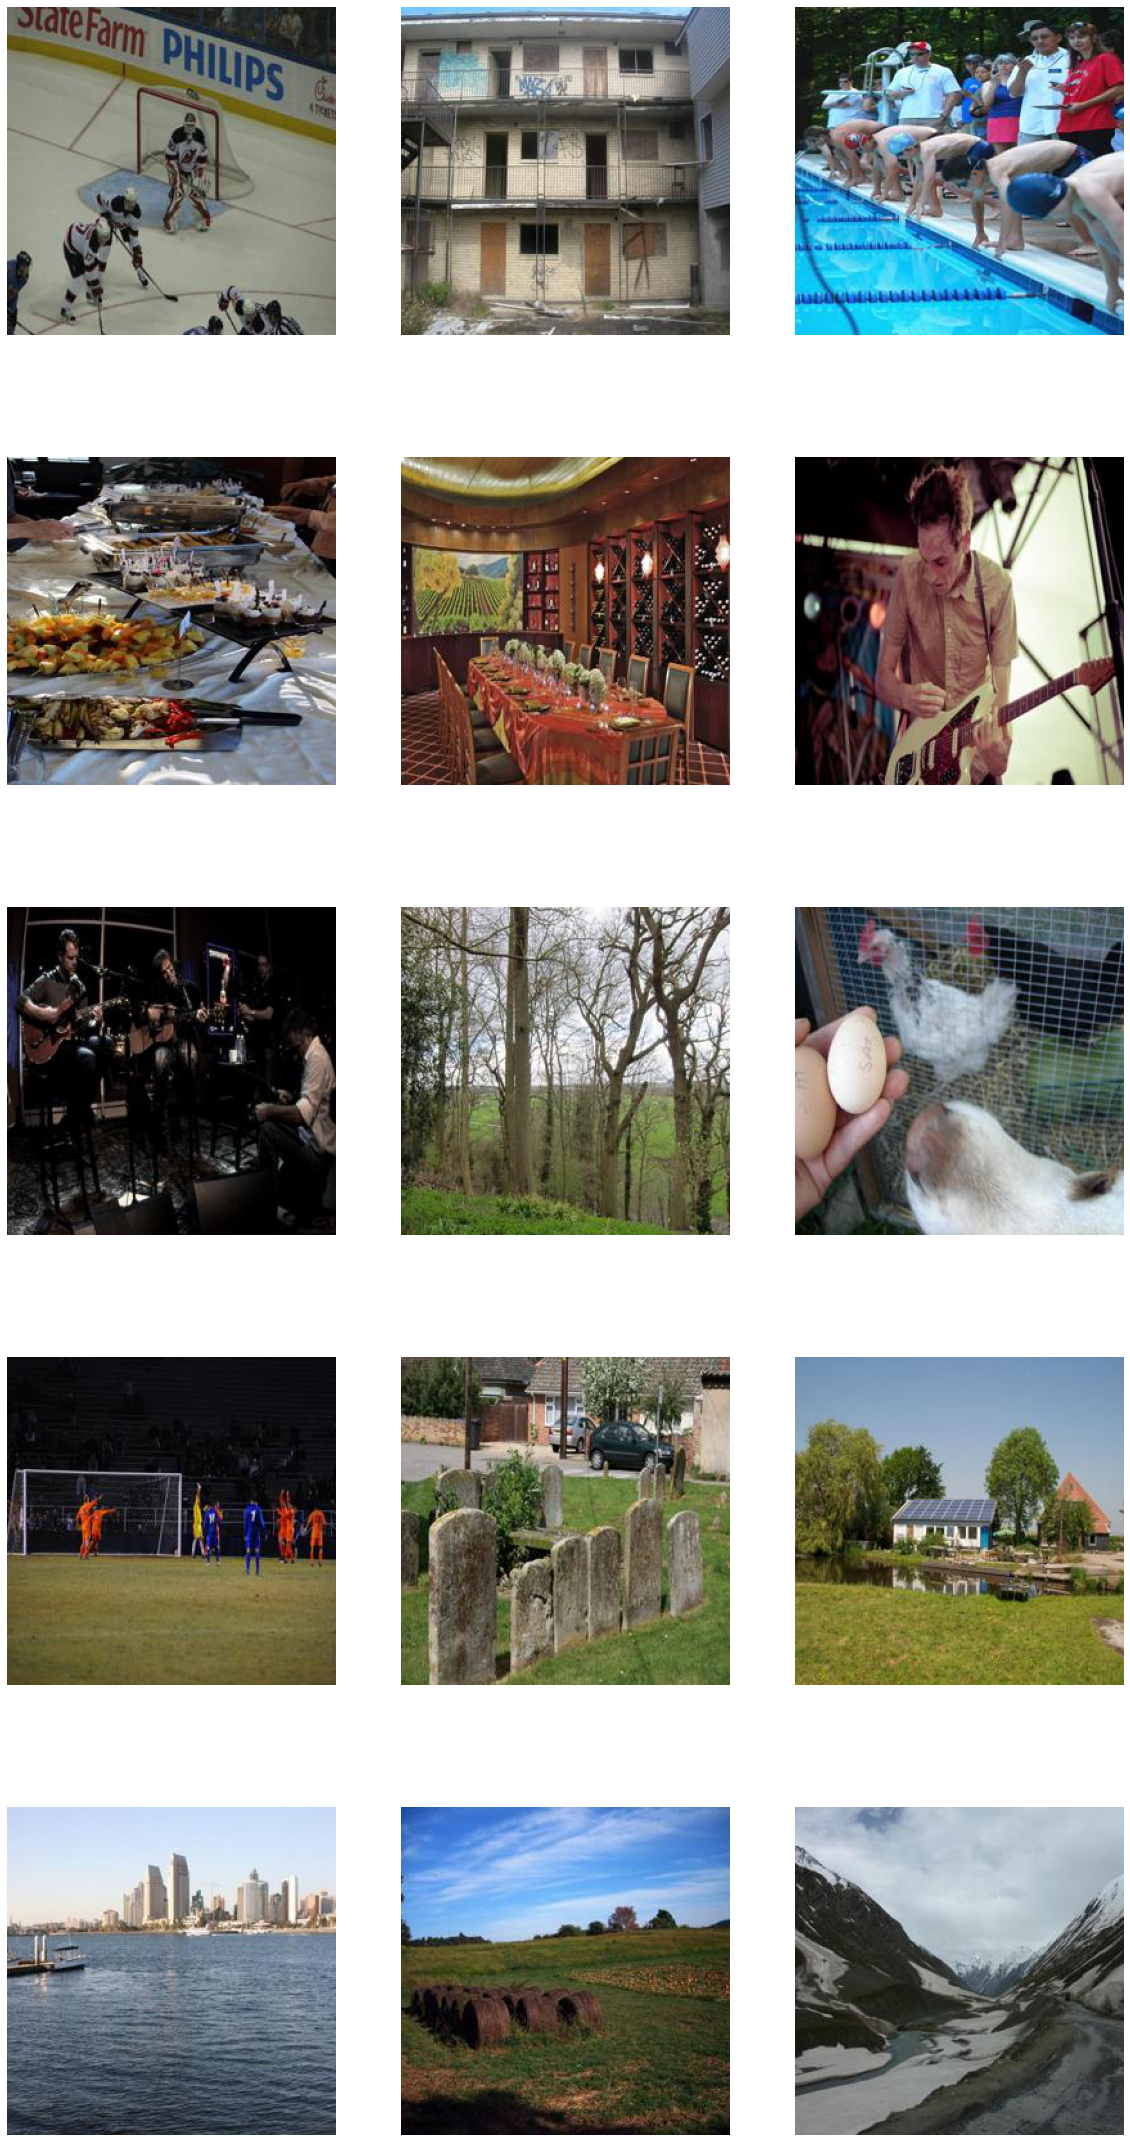

In [32]:
#@title
#Code for displaying sample non-memes
rows = 5
path= '/content/drive/My Drive/Memes_Project/Data/memes_vs_non_memes/train/non_meme'

os.chdir(path)
files=os.listdir(path)
files=files[30:45]


plt.figure(figsize=(20,40))
for num, f in enumerate(files):
  try:
    img = PIL.Image.open(f)
    plt.subplot(rows,3,num+1)
    plt.axis('off')
    plt.imshow(img)

  except Exception as e:  # in the interest in keeping the output clean...
    pass

###Libraries
For this project I used `keras` API from `tensorflow` along with other libraries like `numpy` ,`sklearn`,`matplotlib`, `random` etc. 

###Workflow
I started with data preparation, where I split the data in training, validation and test data. Then, I loaded the VGG-16 model and used it to classify memes and non-memes with its default hyperparameters. After acquiring results, I checked for accuracy and categorical cross entropy and then used different hyperparameters like `optimizer`, `learning rate`, etc. to fin-tune the model and see which combination provided the best accuracy for training, validation and test data. In the end, I saved the final model. 

##Mount the Google Drive

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

##Importing Libraries


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization,Conv2D,MaxPool2D,Dropout,Input
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

##Data Preparation

In [4]:
os.chdir('/content/drive/My Drive/Memes_Project/Data')

For the data augmentation process we first need to create sub directories for image data. The following code creates these sub-directories and then random images are shiffled in train, test and validation folders.

In [5]:
if os.path.isdir('memes_vs_non_memes/train/meme') is False:
  os.makedirs('memes_vs_non_memes/train/meme')
  os.makedirs('memes_vs_non_memes/train/non_meme')
  os.makedirs('memes_vs_non_memes/valid/meme')
  os.makedirs('memes_vs_non_memes/valid/non_meme')
  os.makedirs('memes_vs_non_memes/test/meme')
  os.makedirs('memes_vs_non_memes/test/non_meme')

  for c in random.sample(glob.glob('meme*'),6400):
    shutil.move(c,'memes_vs_non_memes/train/meme')
  for c in random.sample(glob.glob('non_meme*'),6400):
    shutil.move(c,'memes_vs_non_memes/train/non_meme')
  for c in random.sample(glob.glob('meme*'),1200):
    shutil.move(c,'memes_vs_non_memes/valid/meme')
  for c in random.sample(glob.glob('non_meme*'),1200):
    shutil.move(c,'memes_vs_non_memes/valid/non_meme')
  for c in random.sample(glob.glob('meme*'),400):
    shutil.move(c,'memes_vs_non_memes/test/meme')
  for c in random.sample(glob.glob('non_meme*'),400):
    shutil.move(c,'memes_vs_non_memes/test/non_meme')


The next step is tp augment the data using `ImageDataGenerator` from `keras` where we will pre-process images and create our training, validation and test batches with a batch size of 100

In [6]:
train_path ='/content/drive/My Drive/Memes_Project/Data/memes_vs_non_memes/train'
test_path='/content/drive/My Drive/Memes_Project/Data/memes_vs_non_memes/test'
valid_path='/content/drive/My Drive/Memes_Project/Data/memes_vs_non_memes/valid'

In [ ]:
train_batches= ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory= train_path,target_size=(224,224),classes=['meme','non_meme'],batch_size=32)
valid_batches= ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory= valid_path,target_size=(224,224),classes=['meme','non_meme'],batch_size=100)
test_batches= ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory= test_path,target_size=(224,224),classes=['meme','non_meme'],batch_size=100,shuffle=False)

**Although I created different batches it is necessary with the datset to create generation instances because there are a couple of images in the dataset that might interrupt the training process. The following code will define a function to check if the batch of images can be used or needs to be passed**

In [8]:
data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

train_gen = data_gen.flow_from_directory(directory= train_path,target_size=(224,224),classes=['meme','non_meme'],batch_size=100)
valid_gen = data_gen.flow_from_directory(directory= valid_path,target_size=(224,224),classes=['meme','non_meme'],batch_size=100)
test_gen= data_gen.flow_from_directory(directory= test_path,target_size=(224,224),classes=['meme','non_meme'],batch_size=100,shuffle=False)

def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

Found 12800 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


##VGG-16



In [ ]:
#This code cell will create a new instance of VGG-16 model and required layers will be added. At the end the model will be compiled with optimizer, metrics and loss function
image_input = Input(shape=(224, 224, 3))

vgg_model = VGG16(input_tensor=image_input, include_top=False,weights='imagenet')

output_classes = 2

vgg16_model_1 = Sequential()
vgg16_model_1.add(vgg_model)
vgg16_model_1.add(layers.Flatten())
vgg16_model_1.add(layers.Dropout(0.2))
vgg16_model_1.add(layers.Dense(output_classes, activation='softmax'))
vgg16_model_1.layers[0].trainable = False
vgg16_model_1.summary()
vgg16_model_1.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#This code will train the model with training data and give training and validation accuracy as well as loss
vgg16_output_1 = vgg16_model_1.fit_generator(my_gen(train_gen),validation_data=valid_gen,epochs=8,steps_per_epoch=train_gen.samples//train_gen.batch_size,validation_steps=valid_gen.samples//valid_gen.batch_size,use_multiprocessing=False,max_queue_size=20,workers=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/8
128/128 [==============================] - 90s 700ms/step - loss: 1.1186 - accuracy: 0.8895 - val_loss: 0.5710 - val_accuracy: 0.9467
Epoch 2/8
128/128 [==============================] - 90s 702ms/step - loss: 0.4303 - accuracy: 0.9598 - val_loss: 0.4742 - val_accuracy: 0.9550
Epoch 3/8
128/128 [==============================] - 87s 680ms/step - loss: 0.3106 - accuracy: 0.9704 - val_loss: 0.3974 - val_accuracy: 0.9604
Epoch 4/8
128/128 [==============================] - 87s 681ms/step - loss: 0.2227 - accuracy: 0.9789 - val_loss: 0.3634 - val_accuracy: 0.9654
Epoch 5/8
128/128 [==============================] - 88s 690ms/step - loss: 0.2010 - accuracy: 0.9818 - val_loss: 0.3581 - val_accuracy: 0.9663
Epoch 6/8
128/128 [==============================] - 88s 684ms/step - loss: 0.1801 - accuracy: 0.9843 - val_loss: 0.3510 - val_accuracy: 0.9663
Epoch 7/8
128/128 [==============================] - 88s 685

In [34]:
#This code cell will define a function to plot the error graph
import pandas as pd
import seaborn as sns


def plotErrorGraph(history,label_title, ep=30):

    ''' 
    This function is used to plot Train Error Vs Validation Error graph
    '''
    plt.figure(figsize=(12, 8))

    loss = history.history['loss']                          # Loss on the training data
    val_loss = history.history['val_loss']                  # Loss on the validation data
    epochs = range(1, ep+1)

    plt.plot(epochs, loss, 'ro-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
    plt.legend()
    plt.title(label_title)

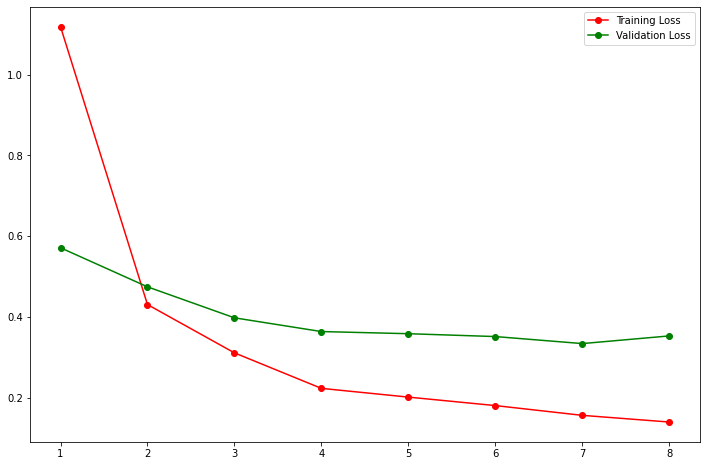

In [ ]:
plotErrorGraph(vgg16_output_1,8)

Now I will check the performance of the model on test data and plot a confusion matrix 

In [ ]:
score_1=vgg16_model_1.evaluate(test_batches)

8/8 [==============================] - 3s 430ms/step - loss: 0.3252 - accuracy: 0.9688


In [ ]:
predictions= vgg16_model_1.predict(x=test_batches,batch_size=100,verbose=0)

In [ ]:
cm= confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

In [12]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

{'meme': 0, 'non_meme': 1}

In [ ]:
cm_plot_labels=['meme','non_meme']

Confusion matrix, without normalization
[[385  15]
 [ 10 390]]


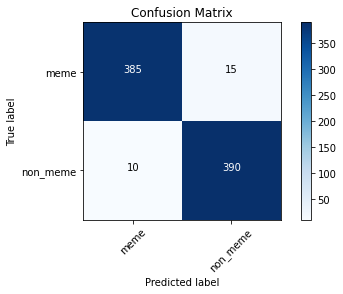

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

##VGG-16 Fine Tuning Hyperparameters


**We have a good VGG-16 model with a high training, validation and test accuracy as well as a high precision of 97% and high recall of 96.25%. In this section I fine tune the model with different dropout rates, lerning rates and optimizers.**

### Dropout Rates

In the following code I used different droput rates to train the model and plotted error graphs to find out which drop out rate provides minimal loss and higher training and validation accuracy

Training VGG-16 model with droput rate of 0.100000
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/8
128/128 [==============================] - 90s 702ms/step - loss: 1.0140 - accuracy: 0.8976 - val_loss: 0.4807 - val_accuracy: 0.9496
Epoch 2/8
128/128 [=====================

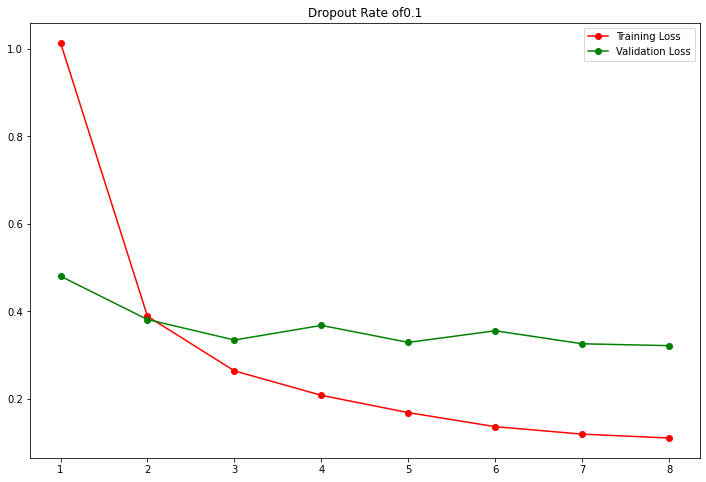

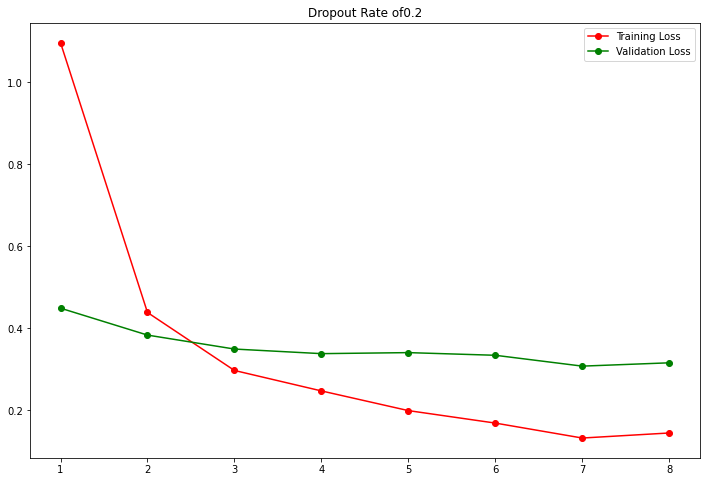

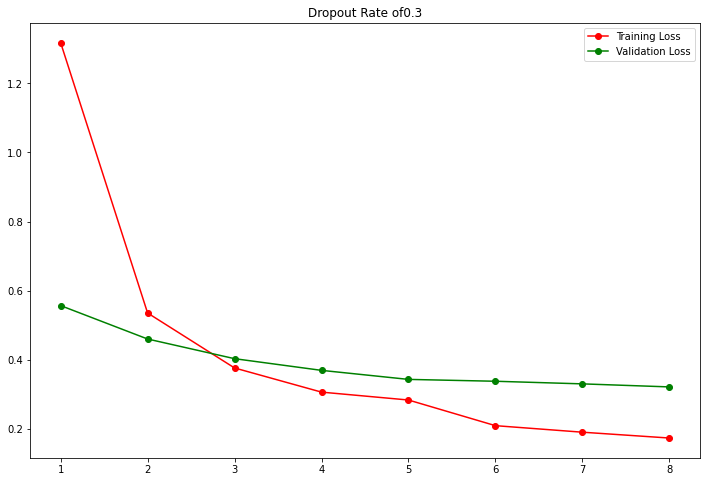

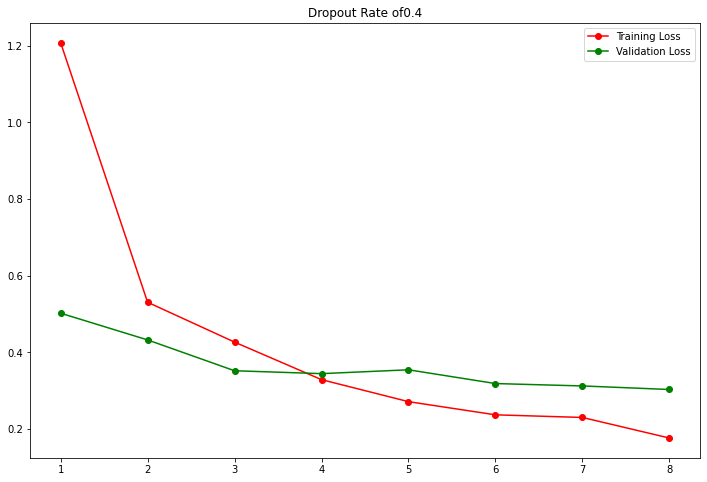

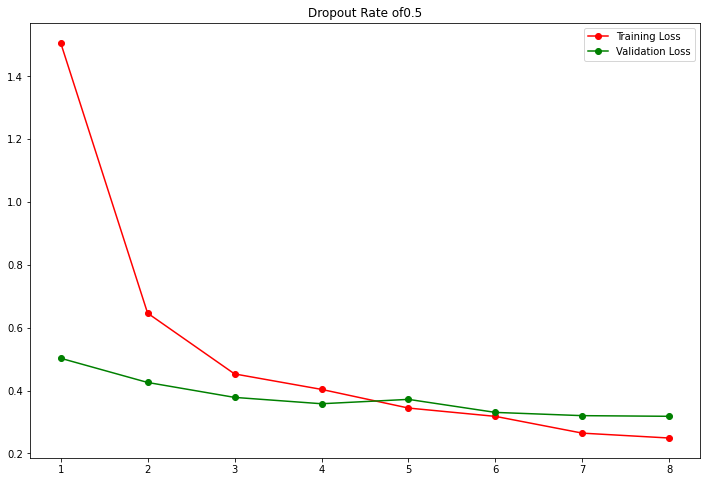

In [ ]:
dropout_rate = [0.1,0.2,0.3, 0.4,0.5]
for i in dropout_rate:
  print("Training VGG-16 model with droput rate of %f"%i)
  vgg16_model = Sequential()
  vgg16_model.add(vgg_model)
  vgg16_model.add(layers.Flatten())
  vgg16_model.add(layers.Dropout(i))
  vgg16_model.add(layers.Dense(output_classes, activation='softmax'))
  vgg16_model.layers[0].trainable = False
  vgg16_model.summary()
  vgg16_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
  vgg16_output = vgg16_model.fit_generator(my_gen(train_gen),validation_data=valid_gen,epochs=8,steps_per_epoch=train_gen.samples//train_gen.batch_size,validation_steps=valid_gen.samples//valid_gen.batch_size,use_multiprocessing=False,max_queue_size=20,workers=1)
  print("Plot for the model with droput rate %f"%i)
  plotErrorGraph(vgg16_output,"Dropout Rate of"+str(i),8)
  print("================================================================================================================================")

From the summary and plots we can observe that drop rate of 0.2 would provide maximum accuracy and minimal loss

###Learning Rates

In the following code I will use different learning rates with a drop out rate of 0.2 to train the model and plotted error graphs to find out which drop out rate provides minimal loss and higher training and validation accuracy

Training VGG-16 model with learning rate of 0.000010
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/8
128/128 [==============================] - 90s 702ms/step - loss: 3.3864 - accuracy: 0.6693 - val_loss: 1.8564 - val_accuracy: 0.7921
Epoch 2/8
128/128 [===================

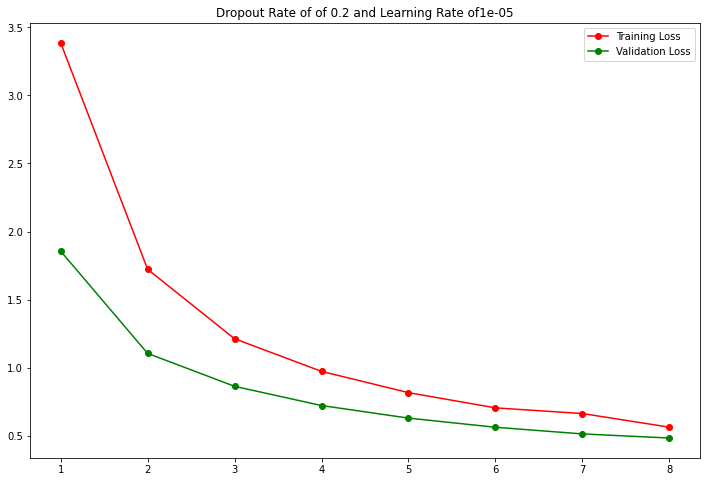

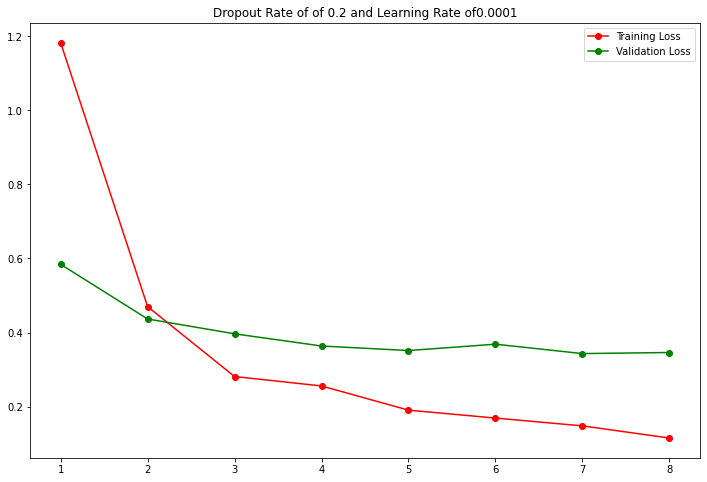

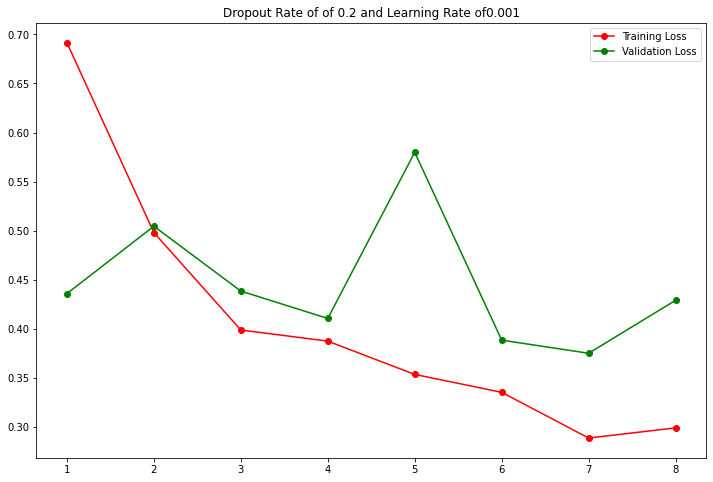

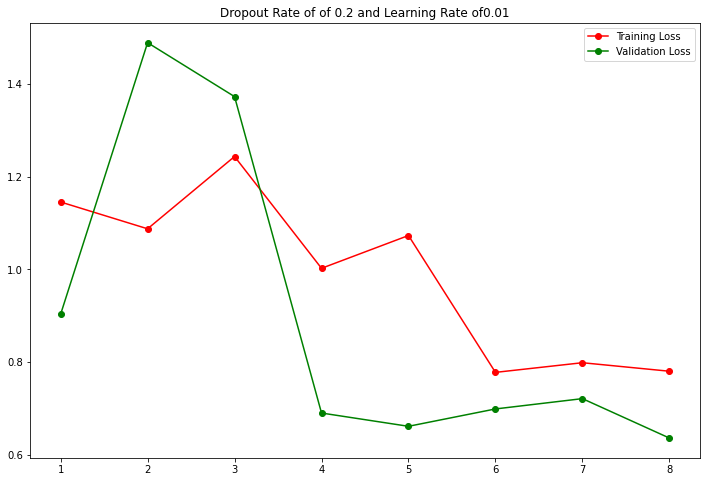

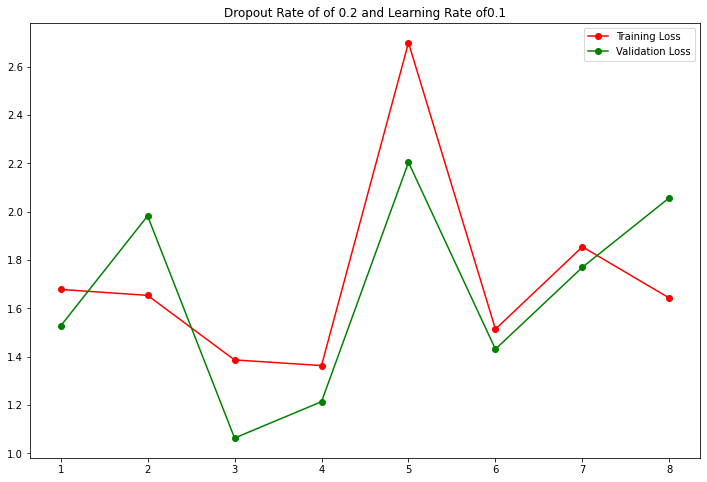

In [ ]:
learning_rate = [1e-5,1e-4,1e-3,1e-2,1e-1]
for lr in learning_rate:
  print("Training VGG-16 model with learning rate of %f"%lr)
  vgg16_model = Sequential()
  vgg16_model.add(vgg_model)
  vgg16_model.add(layers.Flatten())
  vgg16_model.add(layers.Dropout(0.2))
  vgg16_model.add(layers.Dense(output_classes, activation='softmax'))
  vgg16_model.layers[0].trainable = False
  vgg16_model.summary()
  vgg16_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=lr),metrics=['accuracy'])
  vgg16_output = vgg16_model.fit_generator(my_gen(train_gen),validation_data=valid_gen,epochs=8,steps_per_epoch=train_gen.samples//train_gen.batch_size,validation_steps=valid_gen.samples//valid_gen.batch_size,use_multiprocessing=False,max_queue_size=20,workers=1)
  print("Plot for the model with learning rate of %f"%lr)
  plotErrorGraph(vgg16_output,"Dropout Rate of of 0.2 and Learning Rate of"+str(lr),8)
  print("================================================================================================================================")

From the summary and plots we can observe that drop rate of 0.001 would provide maximum accuracy and minimal loss

###Optimizers

In the following code I will use different optimizers with a learning rate of 0.001 and with a drop out rate of 0.2 to train the model and plotted error graphs to find out which drop out rate provides minimal loss and higher training and validation accuracy

Training VGG-16 model with optimizer <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/8
128/128 [==============================] - 92s 715ms/step - loss: 0.6592 - accuracy: 0.9481 - val_loss: 0.5194 - val_accuracy: 0.9

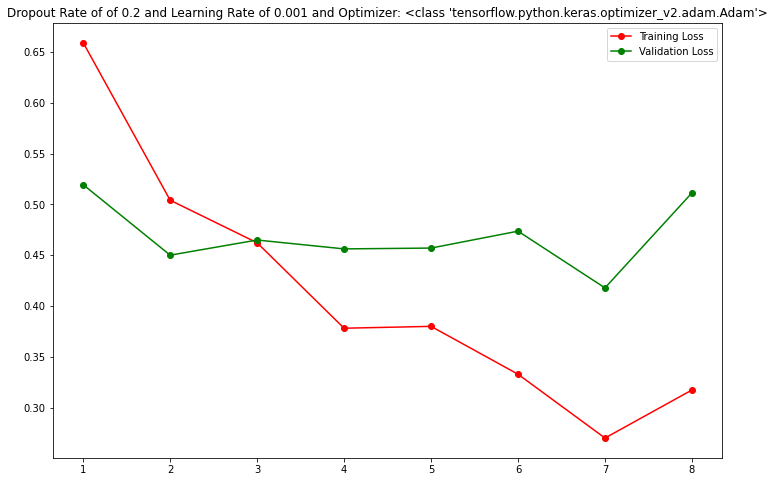

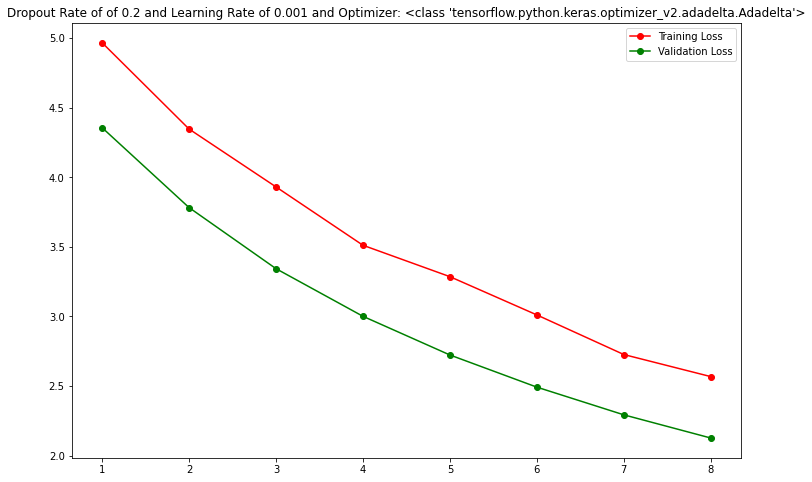

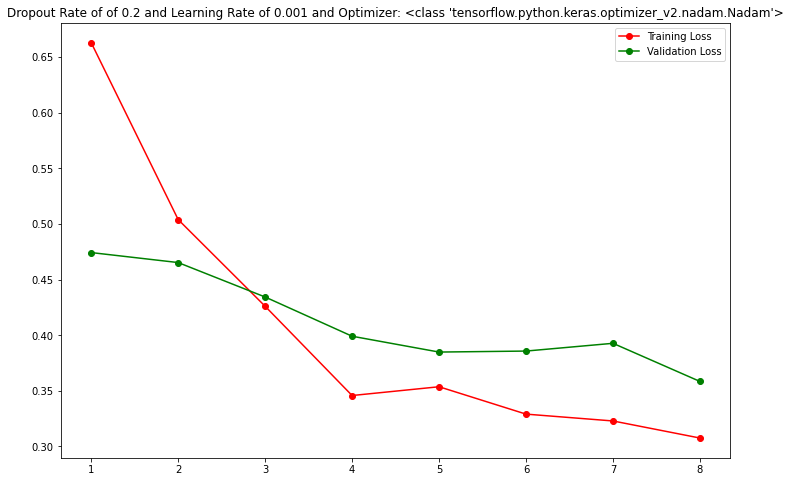

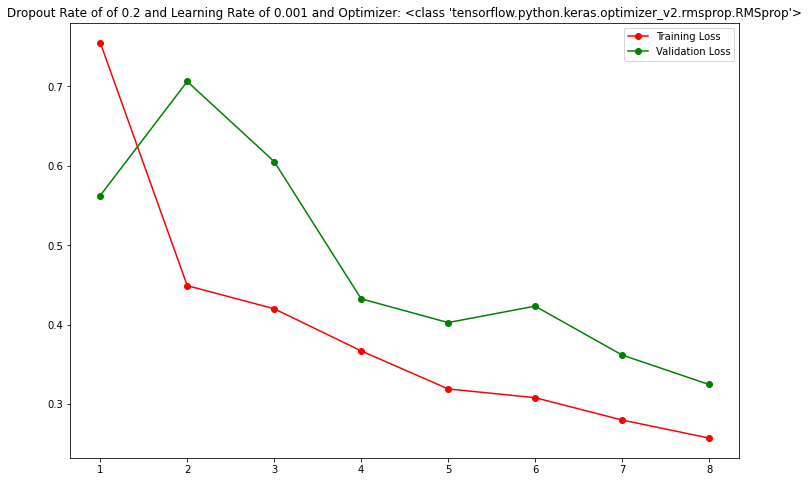

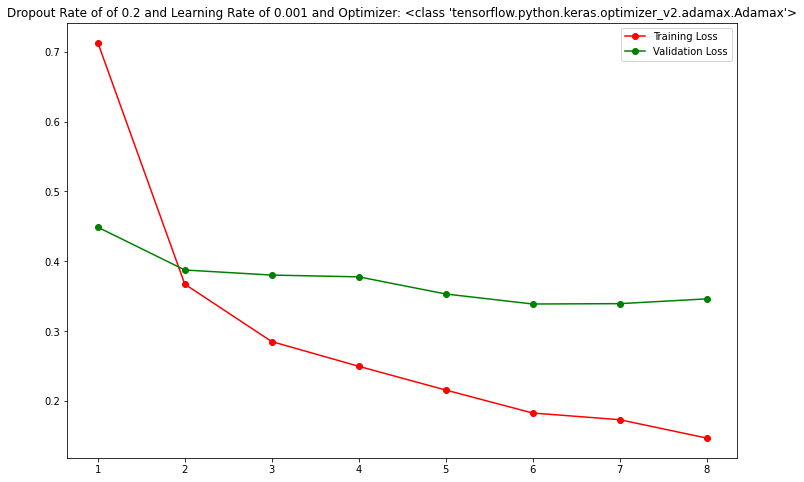

In [ ]:
from keras.optimizers import Adam,Adadelta,Nadam,RMSprop,Adamax
optimizers= [Adam,Adadelta,Nadam,RMSprop,Adamax]
for opt in optimizers:
  print("Training VGG-16 model with optimizer %s"%opt)
  vgg16_model = Sequential()
  vgg16_model.add(vgg_model)
  vgg16_model.add(layers.Flatten())
  vgg16_model.add(layers.Dropout(0.2))
  vgg16_model.add(layers.Dense(output_classes, activation='softmax'))
  vgg16_model.layers[0].trainable = False
  vgg16_model.summary()
  vgg16_model.compile(loss='binary_crossentropy',optimizer=opt(learning_rate=0.001),metrics=['accuracy'])
  vgg16_output = vgg16_model.fit_generator(my_gen(train_gen),validation_data=valid_gen,epochs=8,steps_per_epoch=train_gen.samples//train_gen.batch_size,validation_steps=valid_gen.samples//valid_gen.batch_size,use_multiprocessing=False,max_queue_size=20,workers=1)
  print("Plot for the model with optimizer %s"%opt)
  plotErrorGraph(vgg16_output,"Dropout Rate of of 0.2 and Learning Rate of 0.001 and Optimizer: %s"%opt,8)

##Final Model 
**After determining the hyperparameters that give minimal loss and higher training and validation accuracy, in this section I built and trained the model combining all these hyperparameters.** 

In [11]:
image_input = Input(shape=(224, 224, 3))
vgg_model = VGG16(input_tensor=image_input, include_top=False,weights='imagenet')
output_classes = 2
vgg16_final_model = Sequential()
vgg16_final_model.add(vgg_model)
vgg16_final_model.add(layers.Flatten())
vgg16_final_model.add(layers.Dropout(0.2))
vgg16_final_model.add(layers.Dense(output_classes, activation='softmax'))
vgg16_final_model.layers[0].trainable = False
vgg16_final_model.summary()
vgg16_final_model.compile(loss='binary_crossentropy',optimizer=Adamax(0.001),metrics=['accuracy'])
vgg16_final_output = vgg16_final_model.fit_generator(my_gen(train_gen),validation_data=valid_gen,epochs=15,steps_per_epoch=train_gen.samples//train_gen.batch_size,validation_steps=valid_gen.samples//valid_gen.batch_size,use_multiprocessing=False,max_queue_size=20,workers=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/15
128/128 [==============================] - 6332s 49s/step - loss: 1.0243 - accuracy: 0.9212 - val_loss: 0.4172 - val_accuracy: 0.9654
Epoch 2/15
128/128 [==============================] - 132s 1s/step - loss: 0.3918 - accura

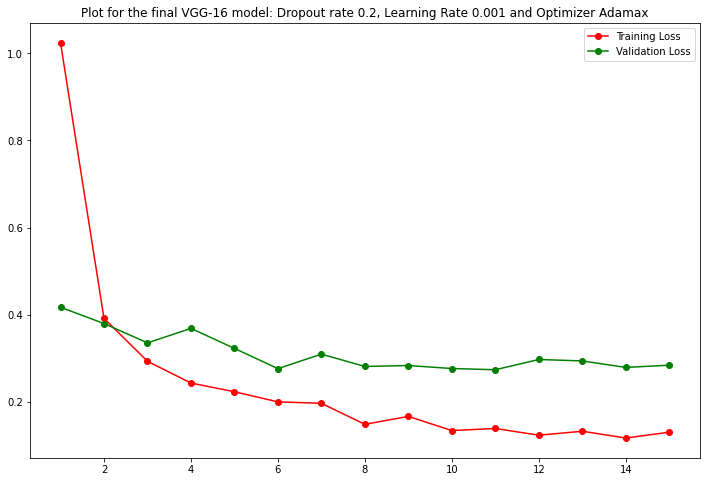

In [35]:
plotErrorGraph(vgg16_final_output,"Plot for the final VGG-16 model: Dropout rate 0.2, Learning Rate 0.001 and Optimizer Adamax",15)

In [13]:
score_final=vgg16_final_model.evaluate(test_batches)
predictions= vgg16_final_model.predict(x=test_batches,batch_size=100,verbose=0)
cm_final= confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))
test_batches.class_indices

8/8 [==============================] - 317s 40s/step - loss: 0.4104 - accuracy: 0.9688


{'meme': 0, 'non_meme': 1}

Confusion matrix, without normalization
[[388  12]
 [ 13 387]]


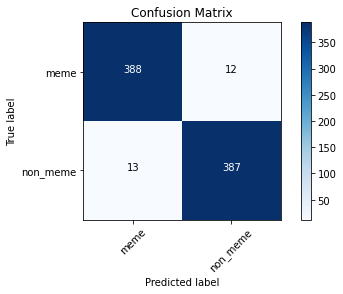

In [14]:
cm_plot_labels=['meme','non_meme']
plot_confusion_matrix(cm=cm_final, classes=cm_plot_labels, title='Confusion Matrix')

In [15]:
cm_final_list= list(cm_final)

In [20]:
#This function will return precision and recall 
def metrics(cm_final_list):
  precision= (cm_final_list[0][0]/(cm_final_list[0][0]+cm_final_list[0][1]))*100
  recall= (cm_final_list[0][0]/(cm_final_list[0][0]+cm_final_list[1][0]))*100
  return precision, recall 


In [21]:
metrics(cm_final_list)

(97.0, 96.75810473815461)

**The model provides a Precision of 97% and Recall of 96.75% when used to classify test data**

##Conclusion and Next Steps
- The final model was built and trained with 15 epochs, a batch size of 100, dropout rate of 0.2, learning rate of 0.001 and Adamax optimizer.
- VGG-16 model when fine tuned gives great accuracy and minimal loss for training and validation dataset as well as test data. The final model provides a Precision of 97% and a recall of 96.75% when used to classify test data.  
- Although the final model acts as a good classifier, there are other pre-trained models like VGG-19, ResNet-50, etc. that should be fine-tuned and check if a higher accuracy model can be built. 